In [144]:
import matplotlib.pyplot as plt
%matplotlib inline
%load_ext autoreload
%reload_ext autoreload
%autoreload 2

import sys, os, time, collections

sys.path.append(os.path.join(os.environ['REPO_DIR'], 'utilities'))
sys.path.append(os.path.join(os.environ['REPO_DIR'], 'cells'))
# sys.path.append(os.path.join(os.environ['REPO_DIR'], 'annotation'))
# sys.path.append(os.path.join(os.environ['REPO_DIR']bb, 'learning'))

import numpy as np
import scipy
import skimage
from skimage.feature import peak_local_max
from skimage.morphology import watershed
from skimage.measure import regionprops, label, find_contours
from skimage.color import rgb2hsv
from scipy import ndimage as ndi
import pandas
from scipy.signal import argrelmax
from scipy.stats import linregress

from annotation_utilities import *
from registration_utilities import *
from learning_utilities import *
from data_manager import *
from utilities2015 import *
from cell_utilities import *
from metadata import *
from distributed_utilities import download_from_s3

from xj_utilities import *# save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/'

# save_folder_path = '/shared/MouseBrainAtlasXiang/XJ/Output/Collect_typical_blobs/'
# fun_create_folder(save_folder_path=save_folder_path)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
scan_parameters = {}

In [4]:
scan_parameters['stack'] = 'MD589'
scan_parameters['patch_size'] = 448
scan_parameters['patch_half_size'] = scan_parameters['patch_size']/2
scan_parameters['stride'] = 112

scan_parameters['section_limits'] = metadata_cache['section_limits'][scan_parameters['stack']]
# Paremters for image reconstruction
scan_parameters['o_crop'] = True
scan_parameters['o_clear_border'] = True
scan_parameters['o_relabel'] = True

scan_parameters['oriImL1'], scan_parameters['oriImL0'] = metadata_cache['image_shape'][scan_parameters['stack']]
scan_parameters['scan_section_range'] = 1

scan_parameters['prop'] = ['centroid','eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter','perimeter','compactness','label','major_axis_length','minor_axis_length']
scan_parameters['prop_for_comparison'] = ['area', 'eccentricity']
if 'moments_hu' in scan_parameters['prop_for_comparison']:
    scan_parameters['compare_weight'] = [1 for i in range(6 + len(scan_parameters['prop_for_comparison']))]
else:
    scan_parameters['compare_weight'] = [1 for i in range(len(scan_parameters['prop_for_comparison']))]
scan_parameters['compare_weight'] = np.array(scan_parameters['compare_weight'])/ float(np.sum(scan_parameters['compare_weight']))
scan_parameters['similarity_threshold'] = 0.9
scan_parameters['o_fix_scan_size'] = True
scan_parameters['scan_size'] = 112
scan_parameters['scan_size_coeff'] = 5
scan_parameters['builtInProps'] = ['centroid','orientation', 'eccentricity','area','orientation','moments_hu','bbox','equivalent_diameter','label','local_centroid','major_axis_length','solidity','minor_axis_length','perimeter','solidity']
scan_parameters['prop_to_save'] = ['coords','moments_hu','centroid','area','eccentricity','equivalent_diameter']
scan_parameters['scan_outside_margin'] = 1000
stack = scan_parameters['stack']

In [20]:
scan_parameters['secList'] = fun_get_valid_section_list(stack=stack)

In [55]:
# Whole image setting:
scan_parameters['crop_0_min'] = 0
scan_parameters['crop_1_min'] = 0
scan_parameters['crop_0_max'] = scan_parameters['oriImL0']
scan_parameters['crop_1_max'] = scan_parameters['oriImL1']
scan_parameters['crop_range_mmxx'] = (scan_parameters['crop_0_min'], scan_parameters['crop_1_min'], scan_parameters['crop_0_max'], scan_parameters['crop_1_max'])
scan_parameters['crop_range_mxmx'] = fun_mmxx_to_mxmx(*scan_parameters['crop_range_mmxx'])
scan_parameters['im0max'] = scan_parameters['crop_0_max'] - scan_parameters['crop_0_min']
scan_parameters['im1max'] = scan_parameters['crop_1_max'] - scan_parameters['crop_1_min']

In [54]:
# margin = 10
# bboxs_7N = {sec:fun_polygon_bbox(vertice_7N_dic[sec]) for sec in sectionList_7N}
# bbox_7N = fun_polygons_bbox(bboxs_7N.values(),margin=margin)
# # bbox_7N = bboxs_7N[154]
# scan_parameters['crop_range_mmxx'] = bbox_7N
# scan_parameters['crop_0_min'], scan_parameters['crop_1_min'],scan_parameters['crop_0_max'],scan_parameters['crop_1_max'] = bbox_7N 
# scan_parameters['im0max'] = scan_parameters['crop_0_max'] - scan_parameters['crop_0_min']
# scan_parameters['im1max'] = scan_parameters['crop_1_max'] - scan_parameters['crop_1_min']
# scan_parameters['crop_range_mxmx'] = fun_mmxx_to_mxmx(*scan_parameters['crop_range_mmxx'])

### Generate grid

In [111]:
patch_size = scan_parameters['patch_size'];
patch_half_size = patch_size / 2;
stride = scan_parameters['stride'];
input_image_1 = scan_parameters['oriImL1'];
input_image_0 = scan_parameters['oriImL0'];

patch_center_pixel_location = grid_parameters_to_sample_locations((patch_size, stride, input_image_0,input_image_1))
patch_ul = patch_center_pixel_location + ( - patch_half_size, - patch_half_size )
patch_ur = patch_center_pixel_location + ( - patch_half_size,   patch_half_size )
patch_dl = patch_center_pixel_location + (   patch_half_size, - patch_half_size )
patch_dr = patch_center_pixel_location + (   patch_half_size,   patch_half_size )
patch_contour = np.array(zip(patch_ul, patch_ur, patch_dr, patch_dl))

### Reconstruct images

In [56]:
section = 152
cell_global_coord = {}
im_blob_prop = {}
im_label_ori = {}
im_label = {}
im_BW = {}
cell_centroids = {}
cell_numbers = {}
fun_mmxx_to_mxmx
scan_range = scan_parameters['scan_section_range']
secList = scan_parameters['secList'] 
sec_load_data_list = range(section - scan_range, section + scan_range + 1)
scan_section = list(sec_load_data_list)
scan_section.remove(section)
tempList = list(sec_load_data_list)
for tempSec in tempList:
    if tempSec in secList:
        cell_global_coord[tempSec] = load_cell_data('coords', stack=stack, sec=tempSec)
        temp_im_label, temp_im_blob_prop, _ = fun_reconstruct_labeled_image(cell_global_coord[tempSec],crop_range= scan_parameters['crop_range_mxmx'], 
                                                                    oriImL0=scan_parameters['oriImL0'],oriImL1=scan_parameters['oriImL1'])
#             im_label[tempSec] = temp_im_label
#             im_BW[tempSec] = temp_im_label > 0
        im_blob_prop[tempSec] = np.array(temp_im_blob_prop)
    else:
        sys.stderr.write('Warning: missing section %d'%tempSec)o_scan_size
        scan_section.remove(tempSec)
        sec_load_data_list.remove(tempSec)

### Eliminate small blobs

In [57]:
blob_prop_dic = fun_regionprops_dic(im_blob_prop=im_blob_prop,scan_parameters=scan_parameters)
blob_idx_selection = {tempSec : np.logical_and.reduce(np.row_stack(
    (blob_prop_dic[tempSec]['compactness']>0,
#      blob_prop_dic[tempSec]['compactness']<2.5,
     blob_prop_dic[tempSec]['area']<3000,
     blob_prop_dic[tempSec]['area']>200))) for tempSec in sec_load_data_list}  

n_blobs = {tempSec: len(im_blob_prop[tempSec]) for tempSec in im_blob_prop.keys()}
secList_in_BlobPropDic = im_blob_prop.keys()
if set(scan_section).issubset(set(secList_in_BlobPropDic)):
    pass
else:
    print('Warrning: Scaned section(s) not included in input im_blob_prop')

### Update labeled images 

In [83]:
blob_selected_coord = {tmpSec:[tmpProp['coords'] for tmpProp in im_blob_prop[tmpSec][blob_idx_selection[tmpSec]]] for tmpSec in sec_load_data_list }
for tmpSec in sec_load_data_list:
    temp_im_label, temp_im_blob_prop,_ = fun_reconstruct_labeled_image(blob_selected_coord[tmpSec], crop_range=scan_parameters['crop_range_mxmx'],oriImL0=scan_parameters['oriImL0'], oriImL1=scan_parameters['oriImL1']);
    im_label[tmpSec] = temp_im_label
    im_blob_prop[tmpSec] = temp_im_blob_prop

### Compute similarity dataset

In [95]:
scan_range = scan_parameters['scan_section_range']
im0max = scan_parameters['im0max']
im1max = scan_parameters['im1max']
prop = scan_parameters['prop']
prop_for_comparison = scan_parameters['prop_for_comparison']
compare_weight = scan_parameters['compare_weight']
o_scan_size = scan_parameters['scan_size'] 

In [196]:
tempSec = scan_section[1]
num_patch = len(patch_center_pixel_location);
patchID = 6000;
patch_scan_range = 1;

In [221]:
current_blobID_list = np.unique(fun_crop_images_2dInput(im_label[section], contour=patch_contour[patchID], im0max=im0max, im1max=im1max)).tolist()
assert 0 in current_blobID_list, current_blobID_list.remove(0)
num_current_blob = len(current_blobID_list);

In [184]:
# Given patchID in section section, get the scan_patchID_list in section tempSec
patch_loc = patch_center_pixel_location/ stride - patch_half_size/stride;
patch_map = np.zeros(np.max(patch_center_pixel_location/ stride - 1, axis=0),dtype=np.int16)
for tmpIdx in range(len(patch_loc)):
    tmpX = patch_loc[tmpIdx][0];
    tmpY = patch_loc[tmpIdx][1];
    patch_map[tmpX, tmpY] = tmpIdx
patch_map_0, patch_map_1 = np.shape(patch_map)
# Get scan patch index
temp_next_sec_range, _ = fun_scan_range(patch_loc[patchID], patch_scan_range, im0max=patch_map_0, im1max=patch_map_1)
scan_patchID_list = fun_crop_images(patch_map, *temp_next_sec_range, im0max=patch_map_0, im1max=patch_map_1).flatten()

In [362]:
# scan_patchID = scan_patchID_list[0]
scan_patchID = 4000
# Get blob props in patches by pologen. Alternatively, can use crop image, but require storing the image in the RAM
tempBlobInside = fun_blobs_in_polygen(blob_prop_dic[tempSec]['centroid'],patch_contour[scan_patchID],coor_order='cr')
tempBlobInsideIndex = np.where(tempBlobInside)[0]
temp_num_blob = len(tempBlobInsideIndex)
temp_weight_sim_matrix = np.zeros([num_current_blob, temp_num_blob], dtype=np.float16)
for tmp_current_blobID_idx in range(len(current_blobID_list)):
    temp_curr_blob_props = {}
    for tempProp in prop:
        temp_curr_blob_props[tempProp] = blob_prop_dic[section][tempProp][current_blobID_list[tmp_current_blobID_idx]]

    if temp_num_blob:
        temp_sim = {}
        for temp_prop in prop_for_comparison:
              temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop], blob_prop_dic[tempSec][temp_prop][tempBlobInside],distance_type=temp_prop))
        temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in prop_for_comparison))
        temp_weight_sim_matrix[tmp_current_blobID_idx,:] = np.dot(temp_sim_matrix,compare_weight)

In [473]:
# Score map: single patch vs whole images
score_map = np.zeros(np.shape(patch_map))
for scan_patchID in range(len(patch_loc)):
    tempBlobInside = fun_blobs_in_polygen(blob_prop_dic[tempSec]['centroid'],patch_contour[scan_patchID],coor_order='cr')
    tempBlobInsideIndex = np.where(tempBlobInside)[0]
    temp_num_blob = len(tempBlobInsideIndex)
    temp_weight_sim_matrix = np.zeros([num_current_blob, temp_num_blob], dtype=np.float16)
    for tmp_current_blobID_idx in range(len(current_blobID_list)):
        temp_curr_blob_props = {}
        for tempProp in prop:
            temp_curr_blob_props[tempProp] = blob_prop_dic[section][tempProp][current_blobID_list[tmp_current_blobID_idx]]

        if temp_num_blob:
            temp_sim = {}
            for temp_prop in prop_for_comparison:
                  temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop], blob_prop_dic[tempSec][temp_prop][tempBlobInside],distance_type=temp_prop))
            temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in prop_for_comparison))
            temp_weight_sim_matrix[tmp_current_blobID_idx,:] = np.dot(temp_sim_matrix,compare_weight)
    score_map[tuple(patch_loc[scan_patchID])] = fun_region_similarity_v1(temp_weight_sim_matrix)

In [478]:
vis_map = score_map.copy()

In [486]:
vis_map = np.power(vis_map,2)

In [492]:
patch_loc[patchID] * stride

array([4928, 6720])

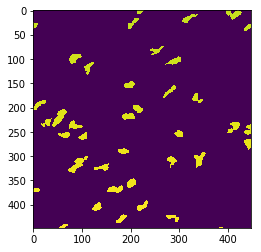

In [490]:
plt.imshow(fun_crop_images_2dInput(im_label[section], contour=patch_contour[patchID], im0max=im0max, im1max=im1max))

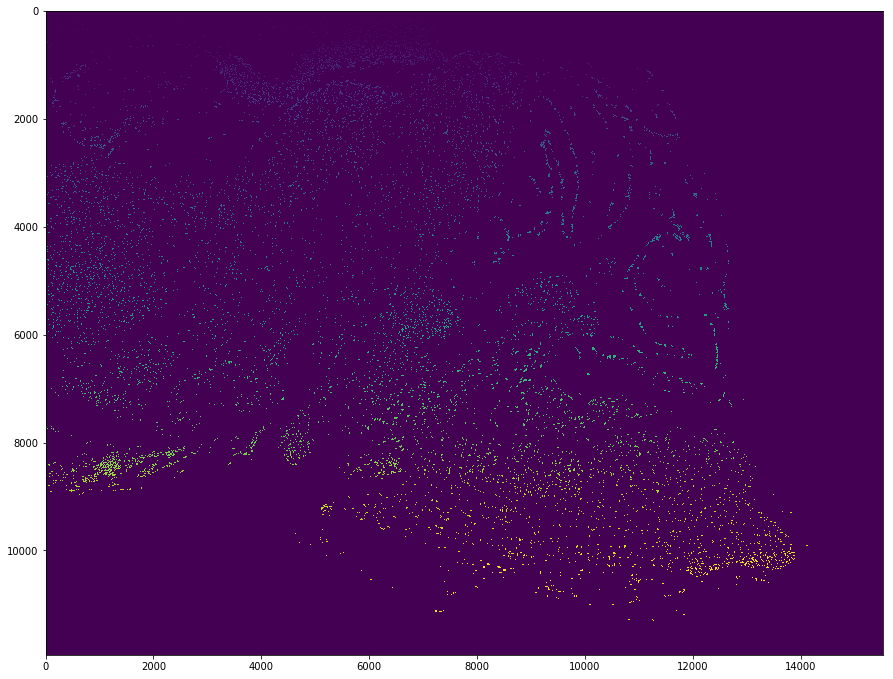

In [493]:
plt.figure(figsize=(15,15))
plt.imshow(im_label[section])

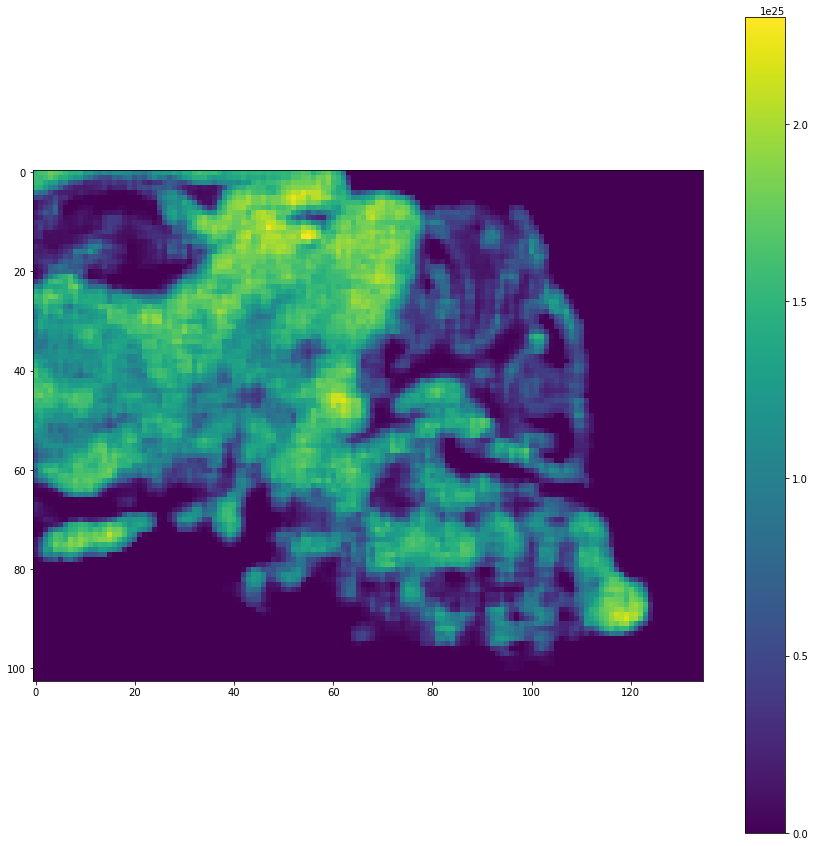

In [487]:
plt.figure(figsize=(15,15))
plt.imshow(vis_map)
plt.colorbar()

In [363]:
np.size(temp_weight_sim_matrix)a

3880

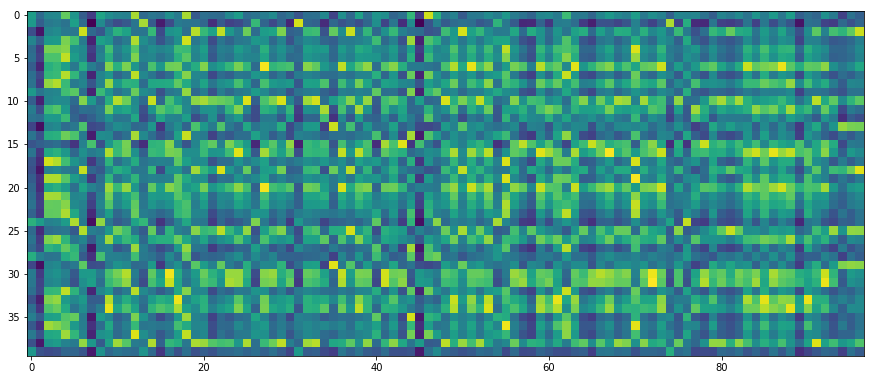

In [364]:
plt.figure(figsize=(15,15))
plt.imshow(np.float64(temp_weight_sim_matrix))


In [468]:
score_matrix = temp_weight_sim_matrix.copy()

In [469]:
matrix_shape = np.shape(score_matrix);
axis_idx_0 = matrix_shape.index(min(matrix_shape))
axis_idx_1 = 1 - axis_idx_0
# matrix_shape.index(max(matrix_shape))
num_iteration = matrix_shape[axis_idx_0]
region_similarity = 0;

### Region Comparison

In [470]:
for iterIdx in range(num_iteration):
    print(np.shape(score_matrix))
    max_pos = tuple(np.argwhere(score_matrix==np.max(score_matrix))[0].tolist())
    region_similarity += score_matrix[max_pos]
    score_matrix = np.delete(score_matrix, (max_pos[axis_idx_1]), axis=axis_idx_1)
    score_matrix = np.delete(score_matrix, (max_pos[axis_idx_0]), axis=axis_idx_0)

(40, 40)
(39, 39)
(38, 38)
(37, 37)
(36, 36)
(35, 35)
(34, 34)
(33, 33)
(32, 32)
(31, 31)
(30, 30)
(29, 29)
(28, 28)
(27, 27)
(26, 26)
(25, 25)
(24, 24)
(23, 23)
(22, 22)
(21, 21)
(20, 20)
(19, 19)
(18, 18)
(17, 17)
(16, 16)
(15, 15)
(14, 14)
(13, 13)
(12, 12)
(11, 11)
(10, 10)
(9, 9)
(8, 8)
(7, 7)
(6, 6)
(5, 5)
(4, 4)
(3, 3)
(2, 2)
(1, 1)


In [400]:
np.shape(score_matrix)

(26, 21)

In [471]:
def fun_region_similarity_v1(score_matrix):
    matrix_shape = np.shape(score_matrix);
    axis_idx_0 = matrix_shape.index(min(matrix_shape))
    axis_idx_1 = 1 - axis_idx_0
    num_iteration = matrix_shape[axis_idx_0]
    region_similarity = 0;
    
    for iterIdx in range(num_iteration):
        max_pos = tuple(np.argwhere(score_matrix==np.max(score_matrix))[0].tolist())
        region_similarity += score_matrix[max_pos]
        score_matrix = np.delete(score_matrix, (max_pos[axis_idx_1]), axis=axis_idx_1)
        score_matrix = np.delete(score_matrix, (max_pos[axis_idx_0]), axis=axis_idx_0)
    return region_similarity

In [472]:
fun_region_similarity_v1(score_matrix)

0

In [335]:
region_similarity

37.79150390625

In [277]:
score_matrix[max_pos[0],:] = 0
score_matrix[:,max_pos[1]] = 0
score_matrix = score_matrix[score_matrix>0]

In [280]:
np.where(score_matrix>0)

(array([   0,    1,    2, ..., 6783, 6784, 6785]),)

In [278]:
np.shape(score_matrix)

(6786,)

In [5]:
contour_df = DataManager.load_annotation_v4(stack=scan_parameters['stack'],by_human=True,suffix='contours',timestamp='latest')
contour_df = convert_annotation_v3_original_to_aligned_cropped(contour_df=contour_df,stack=stack)
structure_name = '7N'
vertice_7N_dic = {record['section']:np.array(record['vertices'],np.int) for _, record in contour_df[contour_df['name']==structure_name].iterrows()}
sectionList_7N = np.sort(vertice_7N_dic.keys())

aws s3 cp --recursive "s3://mousebrainatlas-data/CSHL_labelings_v3/MD589" "/shared/CSHL_labelings_v3/MD589" --exclude "*" --include "*contours*"
latest timestamp:  10042017100807


In [5]:
margin = 10
bboxs_7N = {sec:fun_polygon_bbox(vertice_7N_dic[sec]) for sec in sectionList_7N}
bbox_7N = fun_polygons_bbox(bboxs_7N.values(),margin=margin)
# bbox_7N = bboxs_7N[154]
scan_parameters['crop_range_mmxx'] = bbox_7N
scan_parameters['crop_0_min'], scan_parameters['crop_1_min'],scan_parameters['crop_0_max'],scan_parameters['crop_1_max'] = bbox_7N 
scan_parameters['im0max'] = scan_parameters['crop_0_max'] - scan_parameters['crop_0_min']
scan_parameters['im1max'] = scan_parameters['crop_1_max'] - scan_parameters['crop_1_min']
scan_parameters['crop_range_mxmx'] = fun_mmxx_to_mxmx(*scan_parameters['crop_range_mmxx'])

In [64]:
# Get avaliable sections:
stack = scan_parameters['stack']
section_begin, section_end = scan_parameters['section_limits']
# load_section_num = 40
# load_start_section = 147 - section_begin
load_start_section = min(sectionList_7N) - 5 - section_begin
load_section_num = max(sectionList_7N) -  min(sectionList_7N) + 10
all_valid_section = fun_get_valid_section_list(stack=stack)
secList = all_valid_section[load_start_section:load_section_num + load_start_section]
scan_parameters['secList'] = secList

In [25]:
# # loading data
# image = {}
# for tempSec in secList:
#     try:
#         image[tempSec] = fun_crop_images(DataManager.load_image_v2(stack=stack, section=tempSec, version='jpeg', prep_id=2),*scan_parameters['crop_range_mmxx'],im0max=scan_parameters['oriImL0'],im1max=scan_parameters['oriImL1'] )
#     except:
#         sys.stderr.write('Cannot import section %d...\n'%tempSec)
#         continue

In [ ]:
scan_range = scan_parameters['scan_section_range']
im0max = scan_parameters['im0max']
im1max = scan_parameters['im1max']
prop = scan_parameters['prop']
prop_for_comparison = scan_parameters['prop_for_comparison']
compare_weight = scan_parameters['compare_weight']
o_simil_threshold = scan_parameters['similarity_threshold']
o_fix_scan_size = scan_parameters['o_fix_scan_size']
o_scan_size_coeff = scan_parameters['scan_size_coeff']
o_scan_size = scan_parameters['scan_size']  
secList = scan_parameters['secList'] 
stack = scan_parameters['stack']

data_typical_blobs = {}
data_matched_paris = {}
data_false_typical_blobs = {}
data_false_matched_pairs = {}
data_blob_prop_dic = {}
data_blob_idx_selection = {}
# section = 154
for section in secList:
    typical_blobs = []
    matched_paris = []
    false_typical_blobs = []
    false_matched_paris = []
    cell_centroids = {}
    cell_numbers = {}
    cell_global_coord = {}
    im_blob_prop = {}
    im_label_ori = {}
    im_label = {}
    im_BW = {}
    sec_load_data_list = range(section - scan_range, section + scan_range + 1)
    scan_section = list(sec_load_data_list)
    scan_section.remove(section)
    ### loading data and reconstructed labeled images ###
    tempList = list(sec_load_data_list)
    for tempSec in tempList:
    #         print('process section %d'%tempSec)
        if tempSec in secList:
            cell_global_coord[tempSec] = load_cell_data('coords', stack=stack, sec=tempSec)
    #             print('load section %d'%tempSec)
            temp_im_label, temp_im_blob_prop, _ = fun_reconstruct_labeled_image(cell_global_coord[tempSec],crop_range= scan_parameters['crop_range_mxmx'], 
                                                                        oriImL0=scan_parameters['oriImL0'],oriImL1=scan_parameters['oriImL1'])
#             im_label[tempSec] = temp_im_label
#             im_BW[tempSec] = temp_im_label > 0
            im_blob_prop[tempSec] = np.array(temp_im_blob_prop)
        else:
            sys.stderr.write('Warning: missing section %d'%tempSec)
    #             print(scan_section)
            scan_section.remove(tempSec)
    #             print(scan_section)
    #             print(sec_load_data_list)
            sec_load_data_list.remove(tempSec)
    #             print(sec_load_data_list)

    ### Start getting region properties of each blob    ###
    blob_prop_dic = fun_regionprops_dic(im_blob_prop=im_blob_prop,scan_parameters=scan_parameters)
    data_blob_prop_dic[section] = blob_prop_dic[section] # Save data
    blob_idx_selection = {tempSec : np.logical_and.reduce(np.row_stack(
        (blob_prop_dic[tempSec]['compactness']>0,
    #      blob_prop_dic[tempSec]['compactness']<2.5,
         blob_prop_dic[tempSec]['area']<3000,
         blob_prop_dic[tempSec]['area']>200))) for tempSec in sec_load_data_list}  

    data_blob_idx_selection[section] = blob_idx_selection[section] # Save data

    n_blobs = {tempSec: len(im_blob_prop[tempSec]) for tempSec in im_blob_prop.keys()}
    secList_in_BlobPropDic = im_blob_prop.keys()
    if set(scan_section).issubset(set(secList_in_BlobPropDic)):
        pass
    else:
        print('Warrning: Scaned section(s) not included in input im_blob_prop')



    ### Start scanning ###
    for blobID in range(n_blobs[section]):
        if (blobID % 1000 == 0):
            print('Section %d Finished percentage: %f'%(section, (float(blobID)*100 / n_blobs[section]) ))

        temp_curr_blob_props = {}
        for tempProp in prop:
            temp_curr_blob_props[tempProp] = blob_prop_dic[section][tempProp][blobID]
    #         if tempProp in scan_parameters['builtInProps']:
    #             temp_curr_blob_props[tempProp] = im_blob_prop[section][blobID][tempProp]
    #         elif tempProp == 'compactness':
    #             temp_curr_blob_props[tempProp] = im_blob_prop[section][blobID]['perimeter']**2/(4*PI*im_blob_prop[section][blobID]['area'])

        if not blob_idx_selection[section][blobID]:
    #         print('Blob %d eliminated'%blobID)
            continue



        tempB1_idx_loc = temp_curr_blob_props['centroid']
        if o_fix_scan_size:
            temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max,o_form='2D')
            temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size,im0max=im0max,im1max=im1max)
        else:
            temp_next_sec_range, local_cloc = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max,o_form='2D')
            temp_next_sec_range_1D,_ = fun_scan_range(tempB1_idx_loc,o_scan_size_coeff*fun_radius_bbox(*temp_curr_blob_props.bbox),im0max=im0max,im1max=im1max)


        for tempSec in scan_section:
    #         print('Blbo %d left. Start scanning'%blobID)
            if tempSec not in secList_in_BlobPropDic:
                continue

            # Find blobs at the nearby location in the scaned section
            tempBlobInside = fun_blobs_in_polygen(blob_prop_dic[tempSec]['centroid'],temp_next_sec_range,coor_order='cr')
            tempBlobOutside = fun_blobs_out_polygen(blob_prop_dic[tempSec]['centroid'], temp_next_sec_range, coor_order='cr', margin=scan_parameters['scan_outside_margin'])
            tempBlobInsideIndex = np.where(tempBlobInside)[0]
            temp_num_blob = len(tempBlobInsideIndex)
            tempBlobOutsideIndex = np.where(tempBlobOutside)[0]
            temp_num_outblob = len(tempBlobOutsideIndex)

            ### Typical blobs###

            if temp_num_blob:
                temp_sim = {}
                for temp_prop in prop_for_comparison:
                          temp_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop], blob_prop_dic[tempSec][temp_prop][tempBlobInside],distance_type=temp_prop))
                temp_sim_matrix = np.column_stack((temp_sim[temp_prop] for temp_prop in prop_for_comparison))

                #### Blob comparison ####
                temp_weighted_sim = np.dot(temp_sim_matrix,compare_weight)
                temp_compare_result = temp_weighted_sim > o_simil_threshold
                if any(temp_compare_result.tolist()):
    #                 print('Typical blob found: Blob %d similarity %f'%(blobID,max(temp_weighted_sim)))
                    typical_blobs.append([section,blobID, im_blob_prop[section][blobID]])
                    matched_paris.append([section,blobID,
                                          im_blob_prop[section][blobID],
                                          tempSec,
                                          tempBlobInsideIndex[temp_compare_result],
                                          im_blob_prop[tempSec][tempBlobInsideIndex[temp_compare_result]],
                                          temp_sim_matrix[temp_compare_result,:]])
    #             temp_next_sec_blob_prop = np.array(im_blob_prop[tempSec])[tempBlobInsideIndex]
            else:
    #             print('No blobs found in this section')
                pass

            ### False-typical blobs###
            if temp_num_outblob:
                temp_false_sim = {}
                for temp_prop in prop_for_comparison:
                          temp_false_sim[temp_prop] = np.array(fun_similarity(temp_curr_blob_props[temp_prop], blob_prop_dic[tempSec][temp_prop][tempBlobOutside],distance_type=temp_prop))
                temp_false_sim_matrix = np.column_stack((temp_false_sim[temp_prop] for temp_prop in prop_for_comparison))

                #### Blob comparison ####
                temp_weighted_false_sim = np.dot(temp_false_sim_matrix,compare_weight)
                temp_false_compare_result = temp_weighted_false_sim > o_simil_threshold
                if any(temp_false_compare_result.tolist()):
    #                 print('Typical blob found: Blob %d similarity %f'%(blobID,max(temp_weighted_sim)))
                    false_typical_blobs.append([section,blobID, im_blob_prop[section][blobID]])
                    false_matched_paris.append([section,blobID,im_blob_prop[section][blobID],
                                                tempSec, 
                                                tempBlobOutsideIndex[temp_false_compare_result], 
                                                im_blob_prop[tempSec][tempBlobOutsideIndex[temp_false_compare_result]],
                                                temp_false_sim_matrix[temp_false_compare_result,:]])
    #             temp_next_sec_blob_prop = np.array(im_blob_prop[tempSec])[tempBlobInsideIndex]
            else:
    #             print('No blobs found in this section')
                pass
    # fun_save_typical_blobs_info(typical_blobs=typical_blobs, prop_to_save=scan_parameters['prop_to_save'],stack=stack, sec=section, dataType='typical')
    # fun_save_matched_blobs_info(matched_paris=matched_paris, prop_to_save=scan_parameters['prop_to_save'],stack=stack, sec=section, dataType='matched')
    # fun_save_typical_blobs_info(typical_blobs=false_typical_blobs, prop_to_save=scan_parameters['prop_to_save'],stack=stack, sec=section, dataType='false_typical')
    # fun_save_matched_blobs_info(matched_paris=false_matched_paris, prop_to_save=scan_parameters['prop_to_save'],stack=stack, sec=section, dataType='false_matched')
    data_typical_blobs[section] = typical_blobs
    data_matched_paris[section] = matched_paris
    data_false_typical_blobs[section] = false_typical_blobs
    data_false_matched_pairs[section] = false_matched_paris   

Section 148 Finished percentage: 0.000000
Section 148 Finished percentage: 90.009001
Section 149 Finished percentage: 0.000000
Section 150 Finished percentage: 0.000000
Section 150 Finished percentage: 95.510984
Section 151 Finished percentage: 0.000000
Section 152 Finished percentage: 0.000000
Section 152 Finished percentage: 88.105727
Section 153 Finished percentage: 0.000000
Section 154 Finished percentage: 0.000000
Section 154 Finished percentage: 89.206066
Section 155 Finished percentage: 0.000000
Section 155 Finished percentage: 75.131480
Section 156 Finished percentage: 0.000000
Section 157 Finished percentage: 0.000000
Section 157 Finished percentage: 76.923077
Section 158 Finished percentage: 0.000000
Section 159 Finished percentage: 0.000000
Section 159 Finished percentage: 75.357950
Section 160 Finished percentage: 0.000000
Section 160 Finished percentage: 71.633238
Section 161 Finished percentage: 0.000000
Section 161 Finished percentage: 60.938452
Section 162 Finished perc

In [94]:
# This cell deals with an rare case that section 324 is missing and we load data to section 325, so section 326 is also missing. 
data_typical_blobs.pop(325,None)
data_matched_paris.pop(325, None)
data_false_typical_blobs.pop(325, None)
data_false_matched_pairs.pop(325, None)
data_blob_prop_dic.pop(325,None)
secList.remove(325)

# Analyze typical blobs  - Histograms

In [109]:
# Data processing for all the loaded sections
data_typical_blobs_properties = {}
for tempSec in data_typical_blobs.keys():
    data_typical_blobs_properties[tempSec] = [record[2] for record in data_typical_blobs[tempSec]]

data_typical_blobs_properties = fun_regionprops_dic(data_typical_blobs_properties, scan_parameters)
data_typical_blobs_properties_flatten = {}
# typical_blob_properties, might be dubplicated due to multiple sections matching
for tempProp in scan_parameters['prop']:
    data_typical_blobs_properties_flatten[tempProp] = np.concatenate(tuple([data_typical_blobs_properties[tempSec][tempProp] for tempSec in data_typical_blobs_properties.keys()]))
# dd for delete-duplicated
data_typical_blobs_properties_dd = {}
for tempProp in scan_parameters['prop']:
    data_typical_blobs_properties_dd[tempProp] =  np.concatenate(tuple([data_blob_prop_dic[tempSec][tempProp][np.unique(data_typical_blobs_properties[tempSec]['label'])-1] for tempSec in data_blob_prop_dic.keys()]))
# All detected blob properties in the cropped region
data_blob_prop_dic_flatten = {}
data_selected_blob_props_flatten_dic = {}
for tempProp in scan_parameters['prop']:
    data_blob_prop_dic_flatten[tempProp] = np.concatenate(tuple([data_blob_prop_dic[tempSec][tempProp] for tempSec in data_blob_prop_dic.keys()]))
# All the selected blob properties in the cropped region
temp_selected_idx_flatten = np.logical_and(data_blob_prop_dic_flatten['area']>200, data_blob_prop_dic_flatten['area']<3000)
for tempProp in scan_parameters['prop']:
    data_selected_blob_props_flatten_dic[tempProp] = data_blob_prop_dic_flatten[tempProp][temp_selected_idx_flatten]

In [112]:
# Data processing for all the sections with 7N
data_typical_blobs_properties_7N = {}
for tempSec in sectionList_7N:
    data_typical_blobs_properties_7N[tempSec] = [record[2] for record in data_typical_blobs[tempSec]]
data_typical_blobs_properties_7N = fun_regionprops_dic(data_typical_blobs_properties_7N, scan_parameters)

data_typical_blobs_properties_flatten_7N = {}
# typical_blob_properties, might be dubplicated due to multiple sections matching
for tempProp in scan_parameters['prop']:
    data_typical_blobs_properties_flatten_7N[tempProp] = np.concatenate(tuple([data_typical_blobs_properties_7N[tempSec][tempProp] for tempSec in data_typical_blobs_properties_7N.keys()]))

# dd for delete-duplicated
data_typical_blobs_properties_dd_7N = {}
for tempProp in scan_parameters['prop']:
    data_typical_blobs_properties_dd_7N[tempProp] =  np.concatenate(tuple([data_blob_prop_dic[tempSec][tempProp][np.unique(data_typical_blobs_properties_7N[tempSec]['label'])-1] for tempSec in data_typical_blobs_properties_7N.keys()]))


In [227]:
# All detected blob properties in the cropped region
data_blob_prop_dic_flatten7N = {}
data_selected_blob_props_flatten_dic7N = {}
for tempProp in scan_parameters['prop']:
    data_blob_prop_dic_flatten7N[tempProp] = np.concatenate(tuple([data_blob_prop_dic[tempSec][tempProp] for tempSec in sectionList_7N]))
# All the selected blob properties in the cropped region
temp_selected_idx_flatten7N = np.logical_and(data_blob_prop_dic_flatten7N['area']>200, data_blob_prop_dic_flatten7N['area']<3000)
for tempProp in scan_parameters['prop']:
    data_selected_blob_props_flatten_dic7N[tempProp] = data_blob_prop_dic_flatten7N[tempProp][temp_selected_idx_flatten7N]